# Supplementary figure 2

This notebook contains the functions used to construct the supplementary figure 2 in the paper. 

The figure contains 2 panels:

- a) Exon-centered observed and expected profile of mutations in different tumor types. Compared to Fig. 2a, here the expected number of mutations are using 1,000 random permutations of mutations in each sequence of the stack, as described in the Online Methods

- b) Distribution of gene-level differences of observed and expected exonic mutations numbers in colorectal POLE-mutant tumors.

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.polynomial.polynomial as poly
import matplotlib.ticker as plticker
import gzip, pickle
import os
from os import path

from python_scripts.plot_functions import config_plot_params
from python_scripts.exon_centered_mutational_analysis_supp import obs_exp_muts_rand

In [2]:
config_plot_params()

### Panel a) Exons centered analysis

Following the method described in the **Exon-centered and intron-centered mutational analyses** section, for each exonic position around the center, we computed the observed and expected number of mutations (based on the random permutations). 

### generate data to plot

In [3]:
# Included
clusters_file = 'data/clusters.tsv'
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'

# Not included
mutations_folder = 'non_provided_data/mutations/'

# tumor types to run
listt = ['crc:clusterA', 'ucec:clusterE', 'crc:clusterB',
        'ucec:clusterA', 'bMMRD:clusterA', 'bMMRD:clusterB' ]

In [4]:
middle_distance_threshold = 1000

for ele in listt:
    
    tumor_type, cluster_id = ele.split(":")
    print(tumor_type, cluster_id)
    
    mutations_file = mutations_folder + tumor_type + '.bed.gz'

    exons_centered_results = obs_exp_muts_rand(mutations_file, clusters_file, middle_exons_coords, 
                                               path.join('results', 'signatures.txt'), tumor_type, cluster_id, middle_distance_threshold)

    exons_centered_results.to_csv(path.join('results', "%s_%s_exons_centered_randomized.tsv" % (tumor_type, cluster_id)), 
                                  sep="\t", header=True, index=False)

crc clusterA
ucec clusterE
crc clusterB
ucec clusterA
bMMRD clusterA
bMMRD clusterB


### Plot data 

Exon-centered observed and expected profiles based on permutation analysis. 

In [7]:
def plot_values(ttype, cluster, ax, cnt):
    
    # read observed and backgruond data directly
    filename = "results/%s_%s_exons_centered_randomized.tsv" % (ttype, cluster)
    
    if path.isfile(filename):
    
        data = pd.read_csv(filename, sep="\t")
    
        coefs = poly.polyfit(data['position'], data['muts_count'], 50)
        ffit = poly.polyval(data['position'], coefs)

        ax.plot(data['position'],
                 data['muts_count'], '#e41a1c', alpha=0.5, linewidth=0.7)
        ax.plot(data['position'], ffit, '#e41a1c', linewidth=1)

        coefs2 = poly.polyfit(data['position'], data['expected_muts'], 50)
        ffit2 = poly.polyval(data['position'], coefs2)
        ax.plot(data['position'], ffit2, 'black', linewidth=1, ls="--")

        ax.set_axis_bgcolor('none')

        # show the left spline
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        # add gap between x- and y-axis
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_position(('axes', -0.03))

        ax.yaxis.major.locator.set_params(nbins=4)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlim(-1000, 1000)
        # add axis label
        if cnt in [0, 3]:
            ax.set_ylabel('Number of mutations')
        if cnt >=3:
            ax.set_xlabel('Distance from exon center (bp)')

/home/sabari/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: The fit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/sabari/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RankWarning: The fit may be poorly conditioned
/home/sabari/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


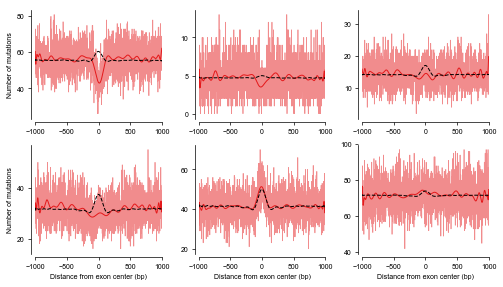

In [8]:
listt = ['crc:clusterA', 'ucec:clusterE', 'crc:clusterB',
        'ucec:clusterA', 'bMMRD:clusterA', 'bMMRD:clusterB' ]

NROW=2
NCOL=3

axs = []

fig = plt.figure(figsize=(7,4))

for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))

cnt=0
for ele in listt:
    ttype, cluster = ele.split(":")
    plot_values(ttype, cluster, axs[cnt], cnt)
    cnt+=1
    
    
plt.tight_layout()
plt.savefig(path.join('figures', 'figureS2A.svg'), bbox_inches='tight')
plt.show()

### Panel b)

Density plot representing the difference between the observed and expected number of exonic mutations in individual genes with at least one expected exonic mutation in colorectal POLE tumors (similar to Fig. 2c).

In [14]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
config_plot_params()

In [16]:
def add_muts(x, y, samplelvl_results_df):
    
    my_gene = x['ensembl']
    sub_samplelvl = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]
    
    exon_muts = sum(sub_samplelvl[y])
    
    return exon_muts

In [17]:
genelevel_plot_lol = list()

clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)


my_ttype = 'crc'
my_cluster = 'clusterA'

gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (my_ttype, my_cluster))  # Output from other notebook
sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (my_ttype, my_cluster))  # Output from other notebook

genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

        
print(my_ttype, my_cluster)

my_genes =  genelvl_results_df['ensembl'].tolist()

my_genelevel_exp = list()

for my_gene in my_genes:
    sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
    sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['enembl'] == my_gene]

    exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
    introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

    exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
    introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

    exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
    intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

    total_muts = exon_muts+intron_muts

    exp_exon_muts = total_muts*exons_prob
    exp_intron_muts = total_muts*introns_prob

    syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
    nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

    syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
    nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

    syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
    nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

    total_cons_muts = syn_muts+nonsyn_muts

    exp_syn_muts = total_cons_muts*syn_prob
    exp_nonsyn_muts = total_cons_muts*nonsyn_prob

    exons_bp = sub_genelvl_results['exons_bp'].values[0]
    introns_bp = sub_genelvl_results['introns_bp'].values[0]

    my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                             exp_intron_muts, syn_muts, exp_syn_muts, nonsyn_muts,
                             exp_nonsyn_muts, exons_bp, introns_bp])

my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                               'exp_intron_muts', 'syn_muts', 'exp_syn_muts', 'nonsyn_muts',
                               'exp_nonsyn_muts', 'exons_bp', 'introns_bp']

my_df = my_genelevel_exp_df

my_df['mutrate'] = ((my_df['exon_muts'] + my_df['intron_muts']) /
                            (my_df['exons_bp'] + my_df['introns_bp']))

my_df['total_muts'] = my_df['exon_muts'] + my_df['intron_muts']
my_df['exons_decrease'] = -(my_df['exp_exon_muts']-my_df['exon_muts'])/my_df['exp_exon_muts']*100
my_df['nonsyn_decrease'] = -(my_df['exp_nonsyn_muts']-my_df['nonsyn_muts'])/my_df['exp_nonsyn_muts']*100

my_df['exp_obs_diff'] = my_df['exon_muts'] - my_df['exp_exon_muts']
my_df['total_bases'] = my_df['exons_bp'] + my_df['introns_bp']

my_df['exp_obs_nonsyn_diff'] = my_df['nonsyn_muts'] - my_df['exp_nonsyn_muts']

my_sub_df = my_df[my_df['exp_exon_muts'] >= 1].copy()

crc clusterA


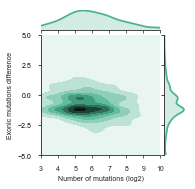

In [18]:
fig = plt.figure(figsize=(4, 2.5))

sns.set(style="ticks")
config_plot_params()

x = np.log2(my_sub_df['total_muts']).tolist()
y = my_sub_df['exp_obs_diff'].tolist()

for i in range(0, len(y)):
    if y[i] <= -5:
        y[i] = -5
        
for i in range(0, len(x)):
    if x[i] >= 10:
        x[i] = 10
        

g = sns.jointplot(np.array(x), np.array(y), kind="kde", color="#4CB391", stat_func=None, size=2.5, 
                  ylim=[-5,5], xlim=[3,10], 
                 ).set_axis_labels("Number of mutations (log2)", "Exonic mutations difference")

g.ax_joint.set_xticks(np.arange(3,11,1))
g.ax_joint.set_yticks([-5, -2.5, 0, 2.5, 5])

plt.savefig(path.join('figures', 'figureS2B.svg'), bbox_inches='tight')
plt.show()